# Clustering Countries based on Quality of COVID-19 Pandemic Response

One topic that we wanted to better understand for this project was to quantify the quality of response a country had to the COVID-19 pandemic. We created metrics for measuring this quality and then ran a clustering algorithm to group countries together based on their quality of response. We first must load all of the necessary packages and data.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

filepath = '/Users/gracemcmonagle/Desktop/School/Fall 2020/EECS 731/Group Project/data/owid-covid-data.csv'
rawData = pd.read_csv(filepath, delimiter = ',')
rawData_nan0 = rawData.fillna(0)

filepath2 = '/Users/gracemcmonagle/Desktop/School/Fall 2020/EECS 731/Group Project/data/OxCGRT_latest.csv'
df = pd.read_csv(filepath2, delimiter = ',')

filepath3 ='/Users/gracemcmonagle/Desktop/School/Fall 2020/EECS 731/Group Project/data/coronanet_release_allvars.csv'
policies = pd.read_csv(filepath3, delimiter = ',')

## Data Analysis

Before we begin with engineering our clustering metrics, let's take a lcosure look at the data we're using above. 

### Our World in Data - Case Counts

The first dataset we will be utilizing is from Our World in Data. The main piece of information we will use from this to answer our question is the per capita new cases per day.

### Policy Dataset #1

The first dataset regarding policies that we will utilize is one that measures specific types of policies that countries have implemented. This dataset measured whether schools were closed, whether countries have stimulated the economy, and whether countries have policies regarding contact tracing or testing among many other things. The creators of this dataset also engineering a stringency index which we will be utilizing.

### Policy Dataset #2

The second dataset we will be using regarding policies is a dataset that tracks individual policies from each country. We utilize this dataset in our experiement with clustering with the policy counts. During the exploratory data analysis phase of our project, we though this graph was particularly interesting from this dataset. 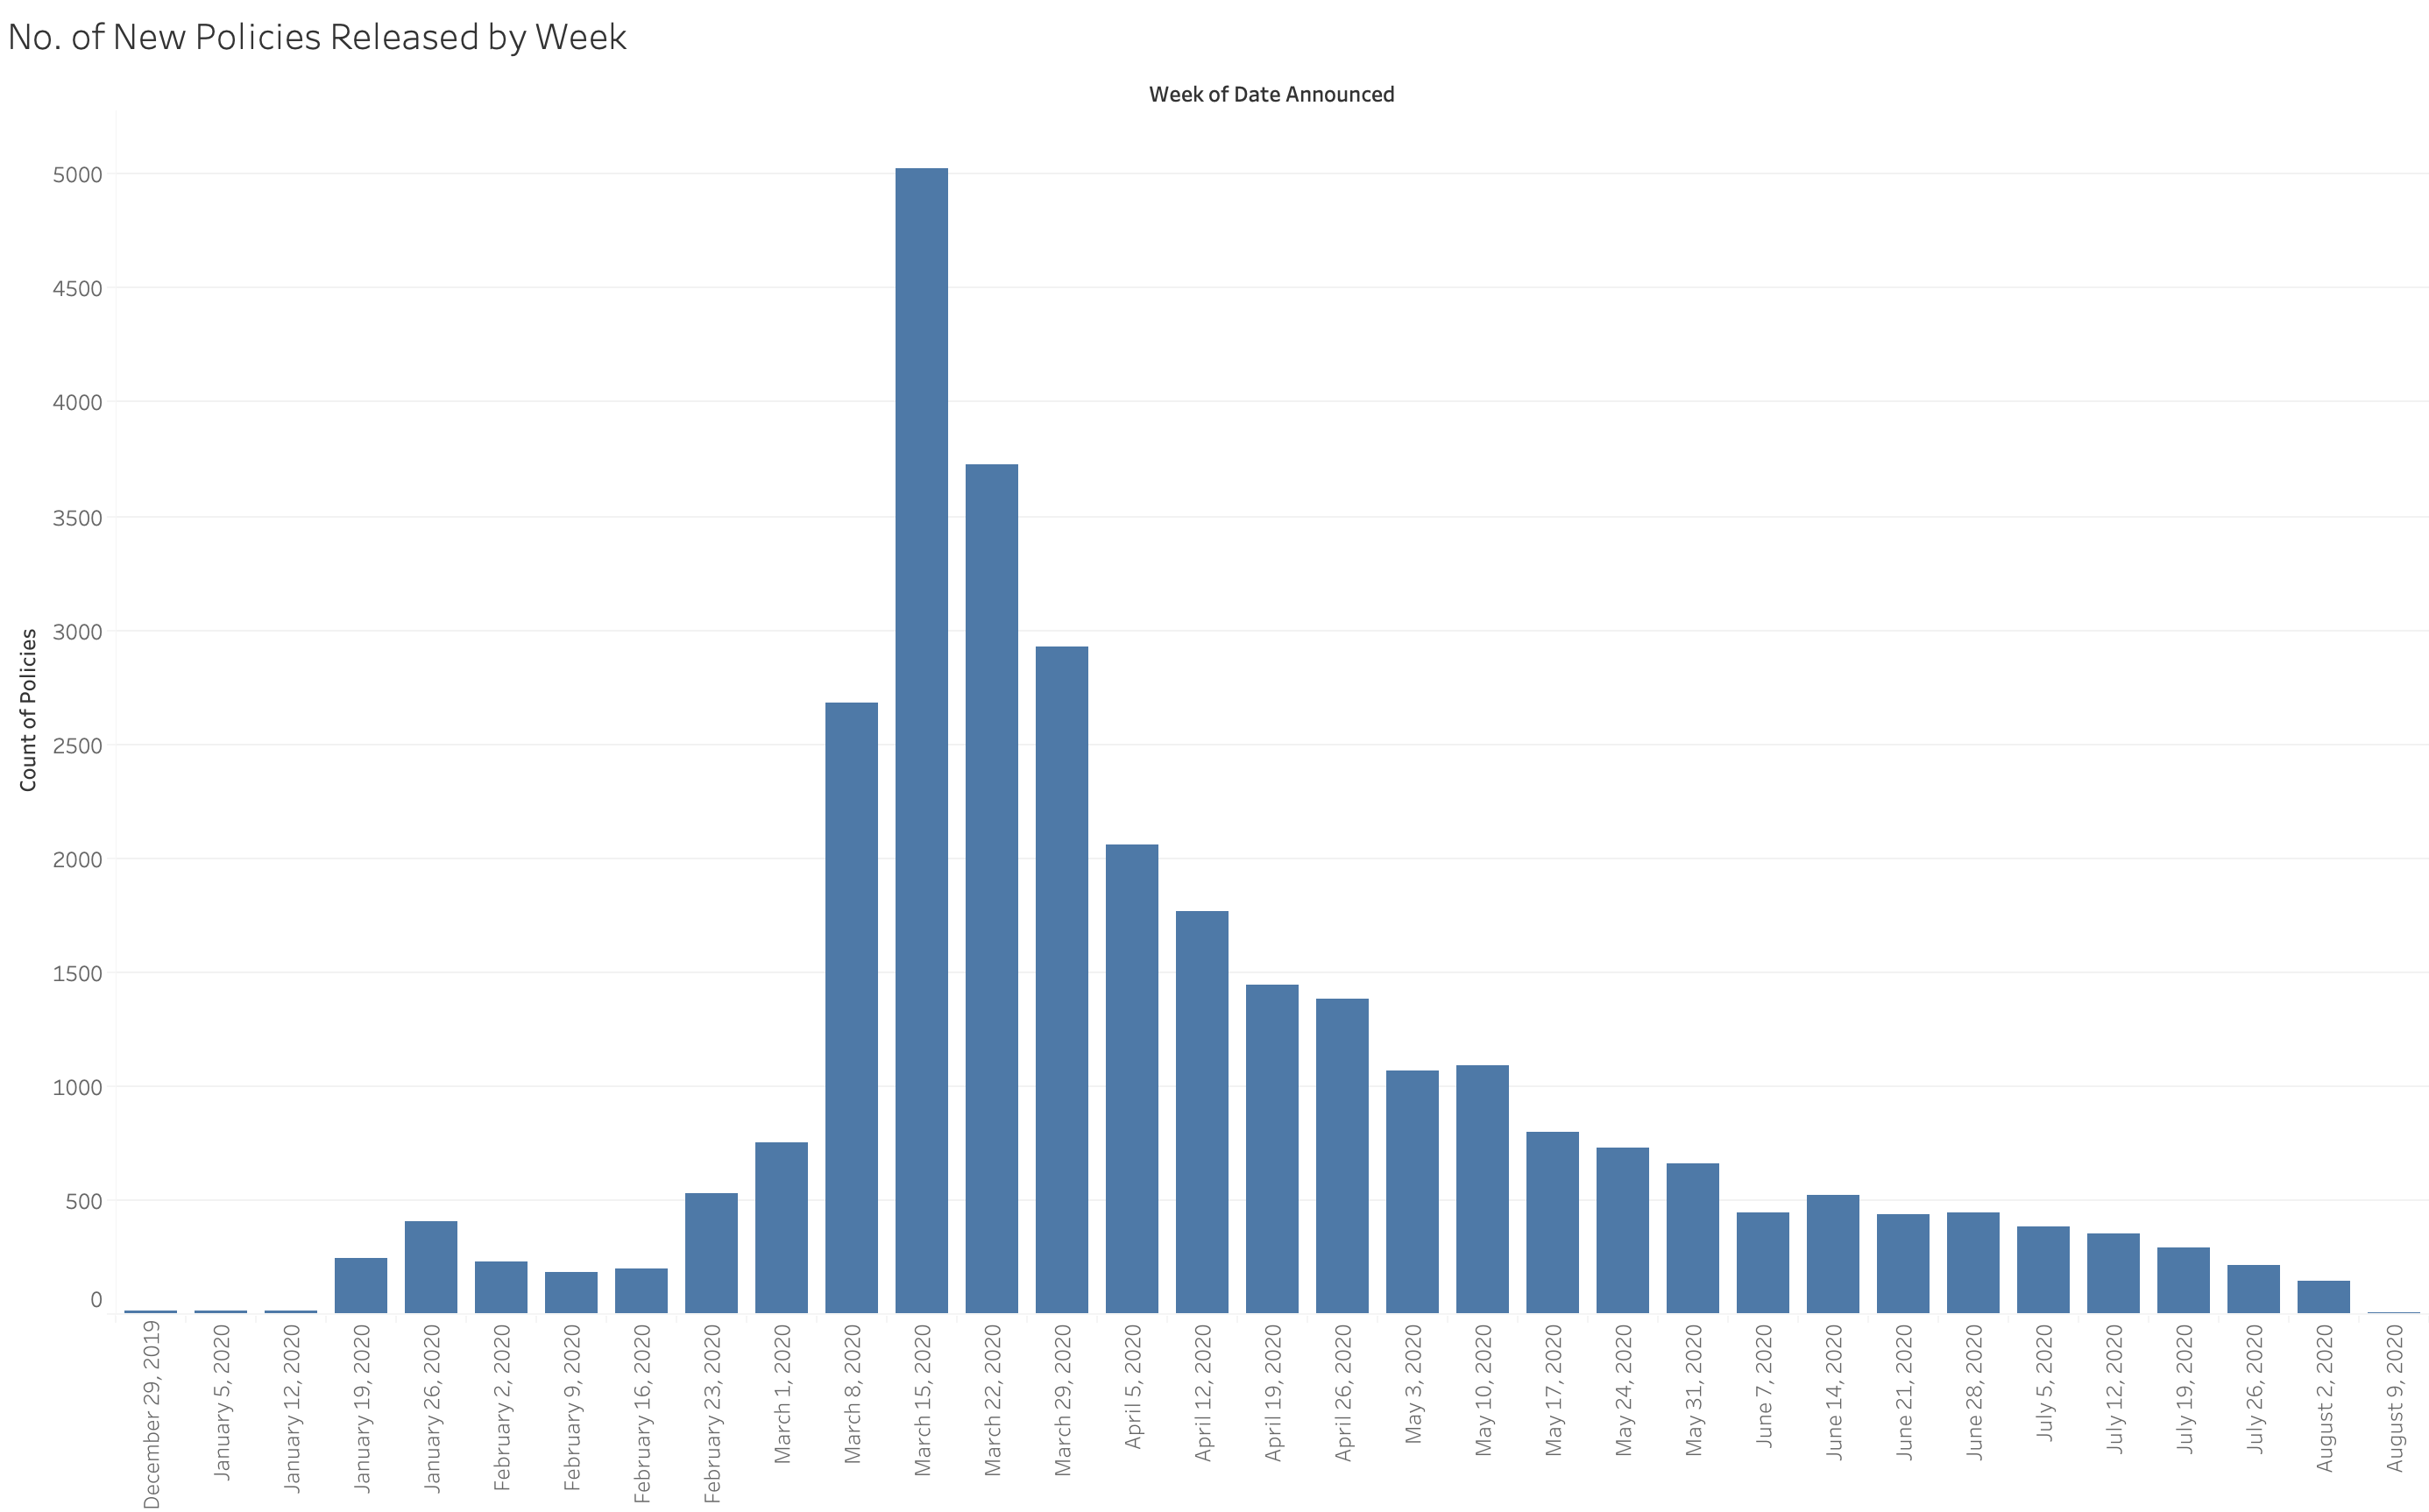

## Clustering Metrics

### Average Case Growth

We must now start creating the metrics we will use to cluster our countries. The first metric we used is measuring the average number of cases each day per country for the pandemic. For this project we took the pandemic to mean January 1, 2020 - November 1, 2020. We averaged the number of new cases per capita per day for each country to give each country a single "caseGrowth" value.

In [39]:
#%% calculate average new number of cases in each country
countries = rawData.iso_code.unique()
avgCaseGrowth = {}
for country in countries:
    is_country = rawData['iso_code'] == country
    avgCG = rawData[is_country].new_cases_per_million.mean()
    avgCaseGrowth[country] = avgCG


caseGrowth = pd.DataFrame.from_dict(avgCaseGrowth, orient='index').rename(columns={0:'caseGrowth'})

We also created bins and made a visual graph of this information.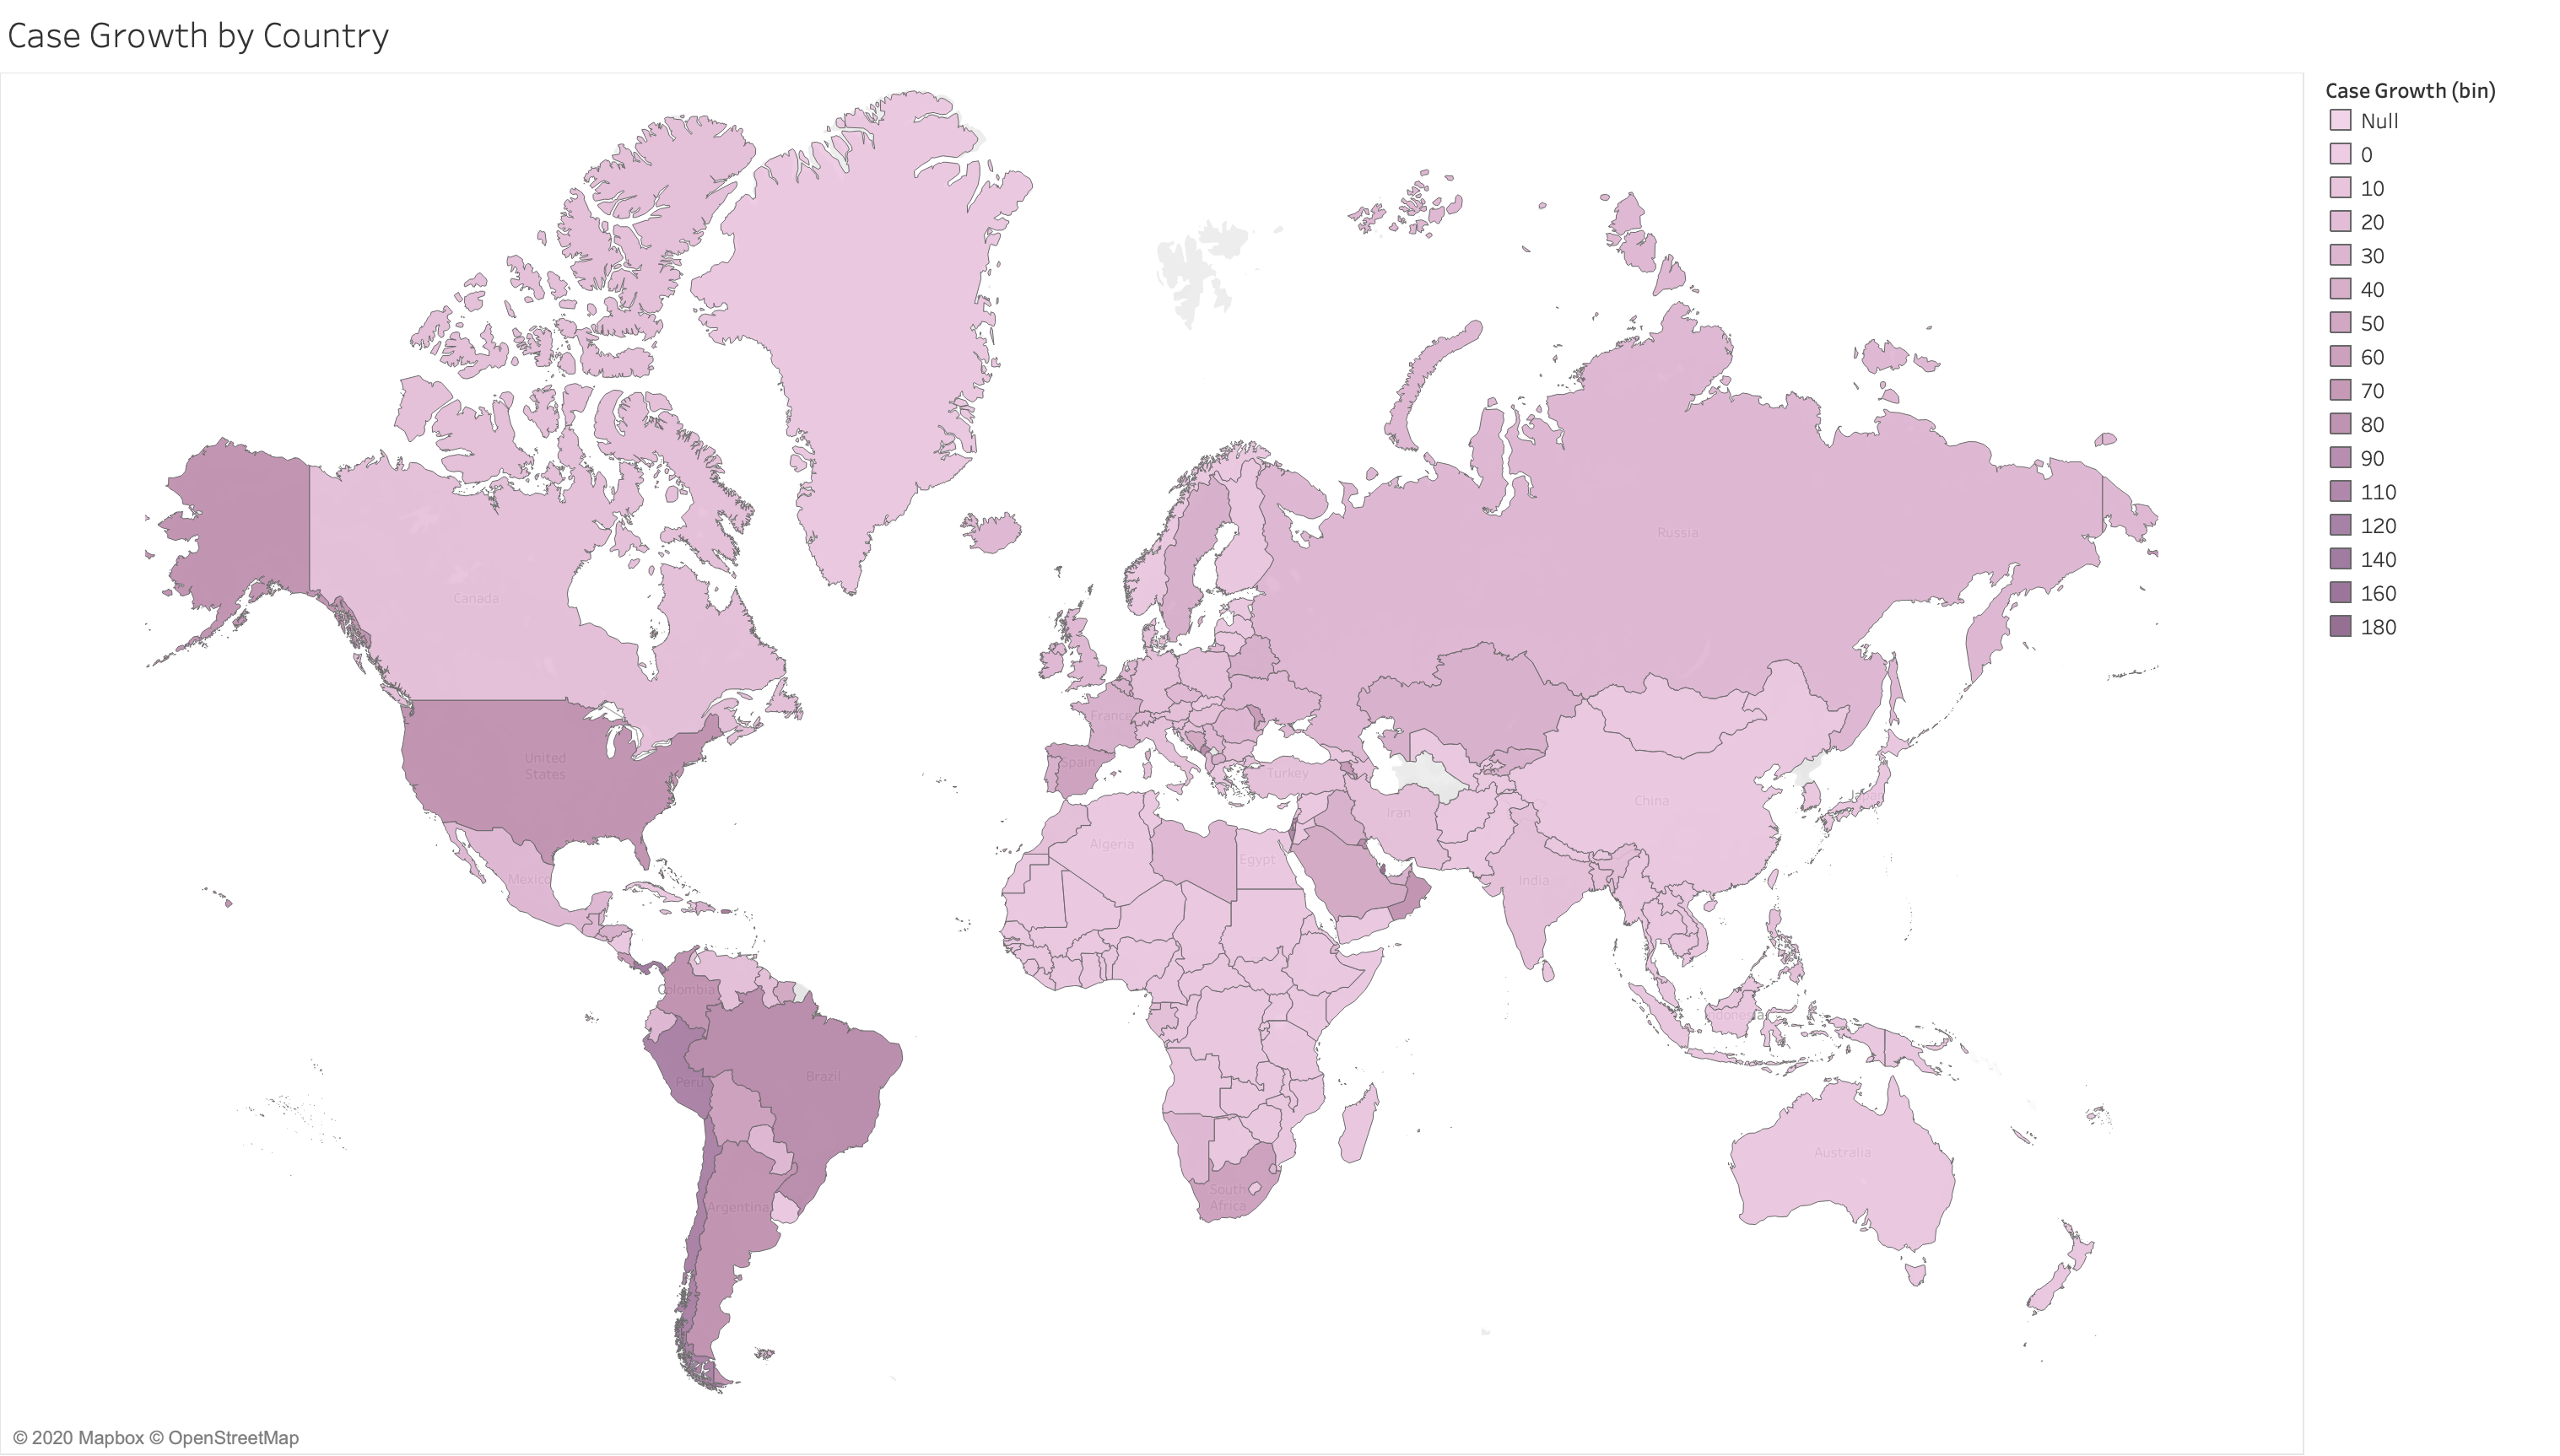

### Average Stringency Index

The next metric is to utilize the Stringency Index available to us in our policy dataset. This stringency index measures the strictness of each country by day of the pandemic. We averaged all of the stringency indices to give each country a single index for the pandemic.

In [40]:
avgStringIndex = {}
for country in countries:
    is_country = df['CountryCode'] == country
    avgSI = df[is_country].StringencyIndex.mean()
    avgStringIndex[country] = avgSI
    
stringIndex = pd.DataFrame.from_dict(avgStringIndex, orient='index').rename(columns={0:'stringIndex'})

We can see this metric on a map. 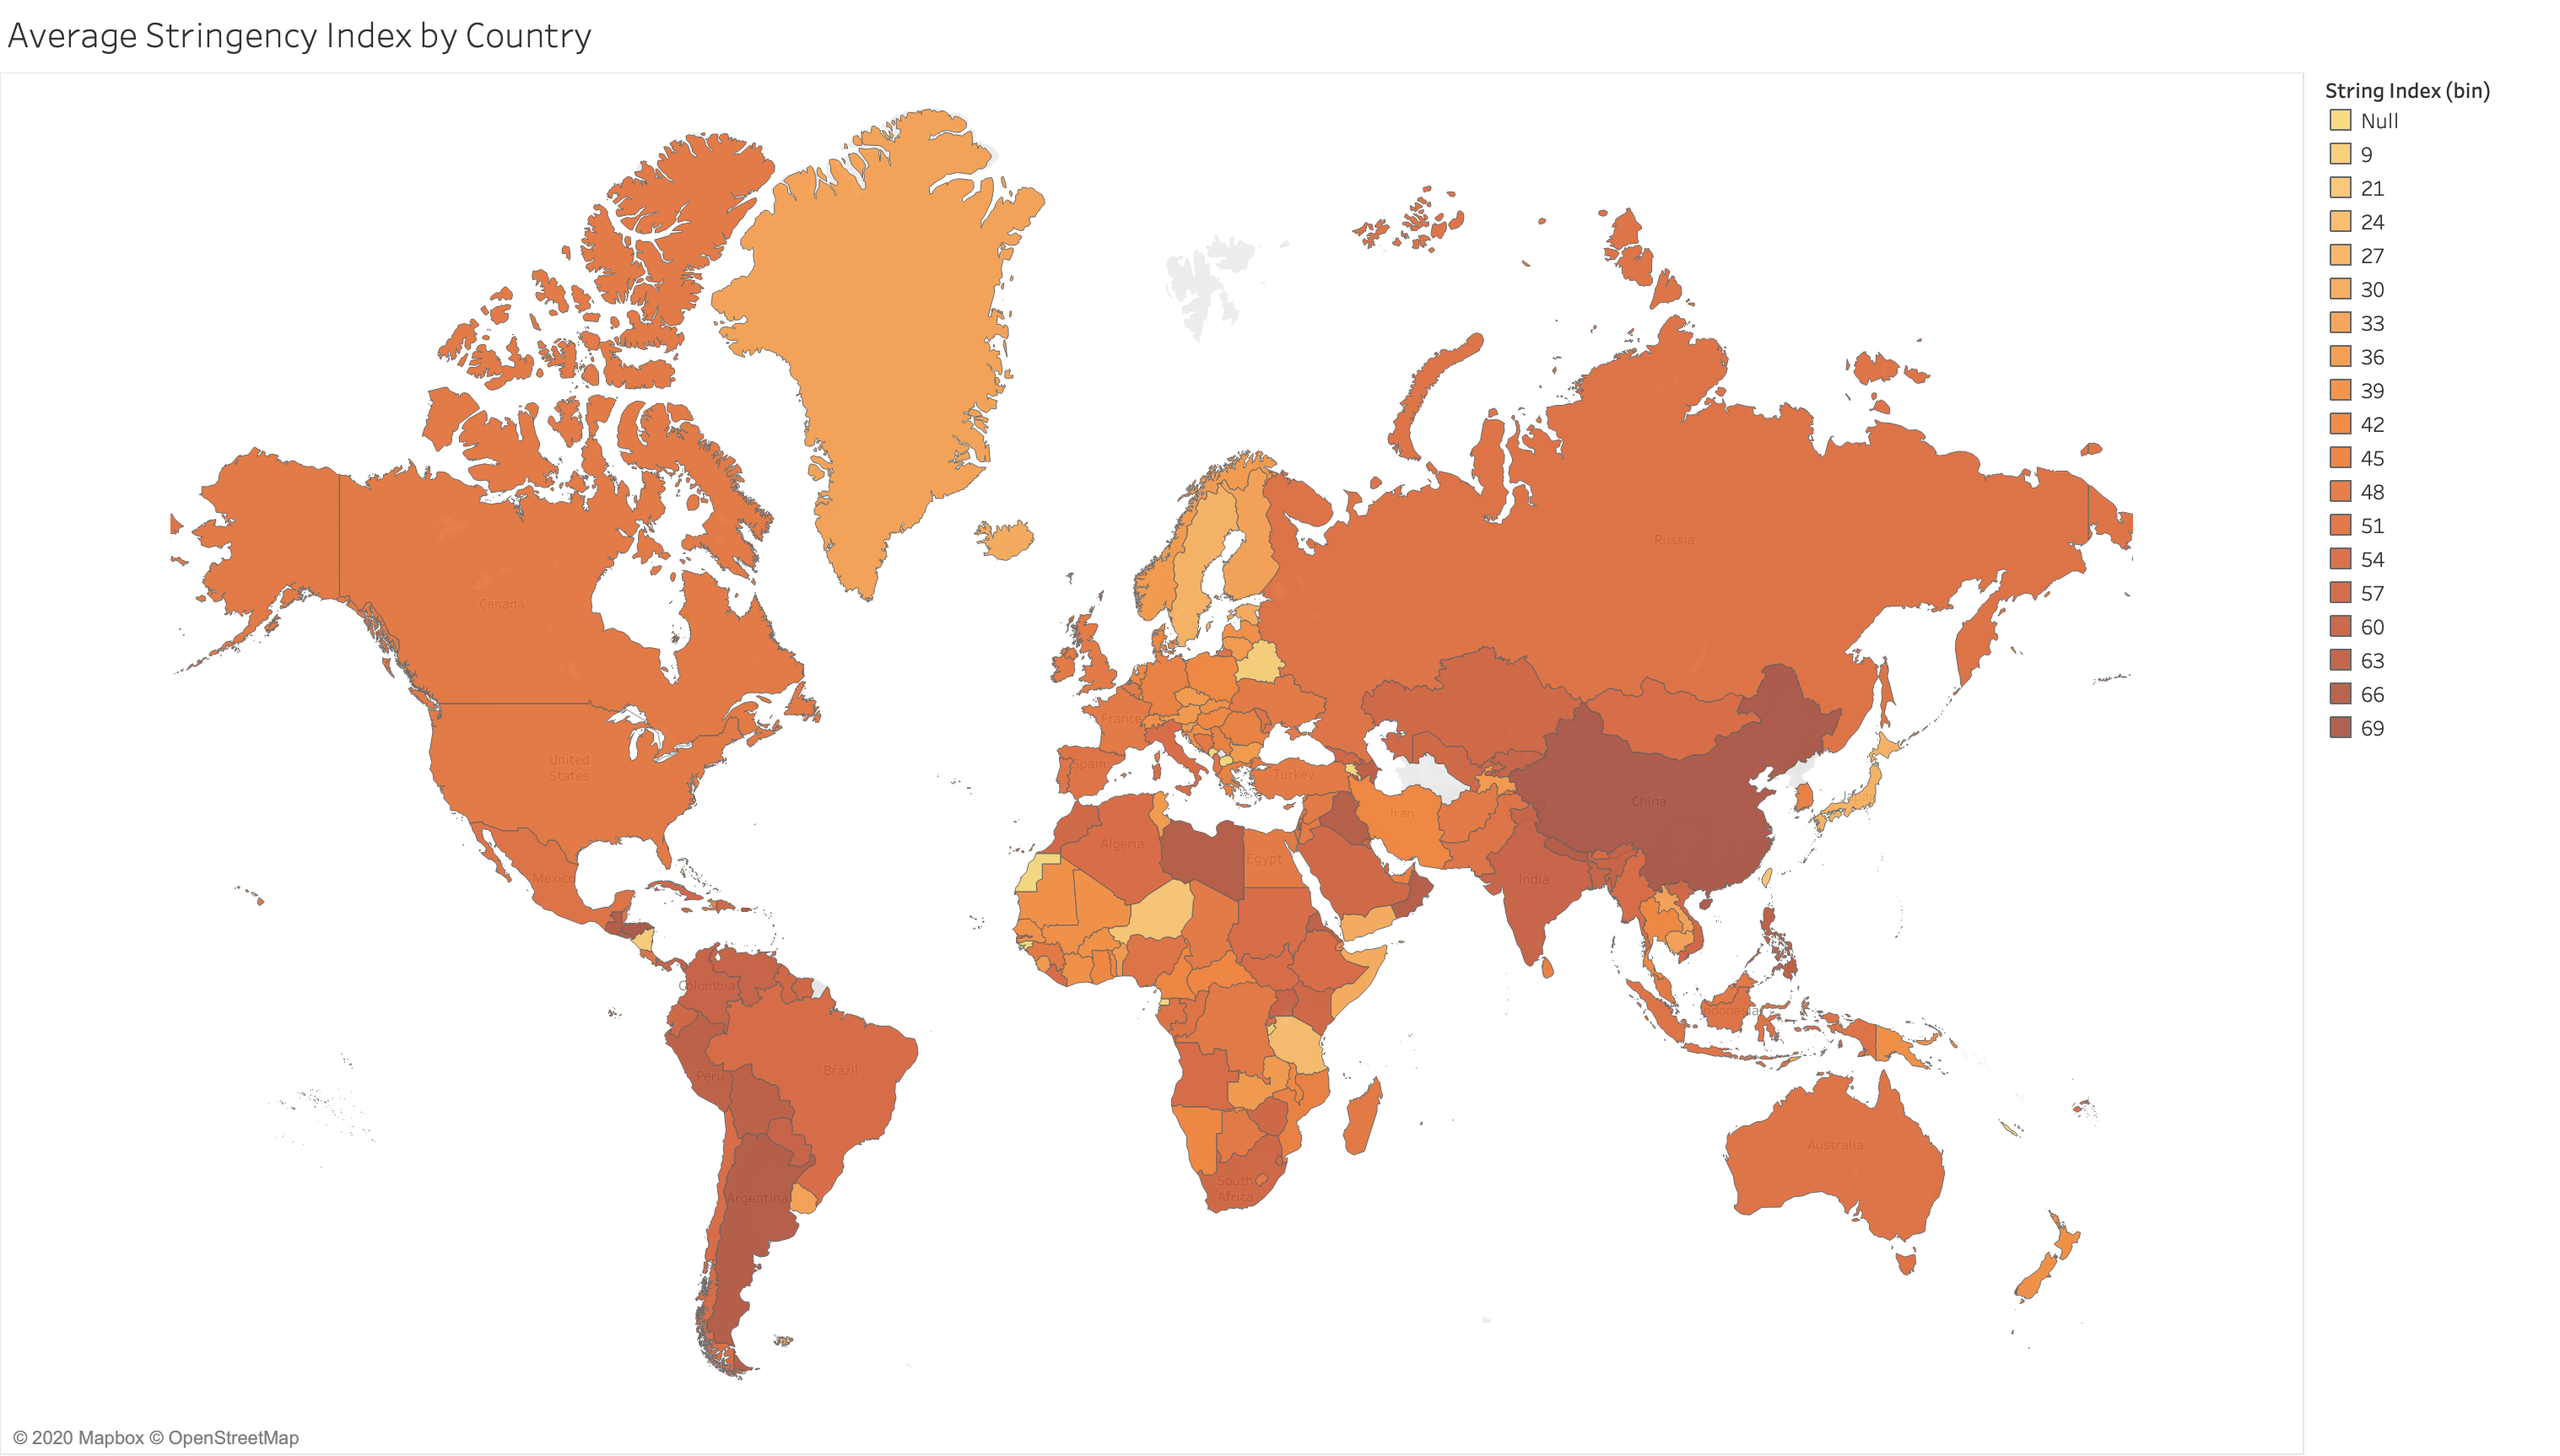

### Days until School Closure

The last metric we ended up utilizing in our clustering algorithm was a measure of how many days into the pandemic schools began to shut down. In our policy dataset, there were 3 levels of school closings. Once any level of mandated school closures began we counted that as the first day of school closing. This metric gives a count of how many days since January 1, 2020 the schools shut down.

In [41]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
c1_flag = df['C1_Flag'] == 1
scClosing = df[c1_flag]

daysBefSClose = {}
for country in countries:
    is_country = scClosing['CountryCode'] == country
    if len(scClosing[is_country]) == 0:
        days = float('NaN')
    else:
        days = (scClosing[is_country]['Date'].iloc[0] - datetime.strptime('01012020', '%m%d%Y')).days
    daysBefSClose[country] = days
    
daysSClose = pd.DataFrame.from_dict(daysBefSClose, orient = 'index').rename(columns = {0: 'DaysBeforeSClose'})

## Data Exploration of Engineered Values

Before we begin clustering with these values we wanted to understand how these values interacted with each other. It could be a cause for concern that these values may not be independent. For the rest of this project we assume that they are, but let's take a closer look at these anyway. 

The first variables we want to investigate are the stringency index and the average number of cases per day. To get a sense of this we plotted them on opposing axes. 

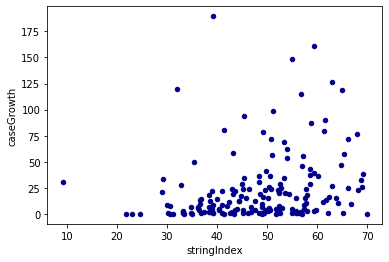

In [42]:
full = pd.concat([caseGrowth, stringIndex, daysSClose], axis = 1).dropna()
ax1 = full.plot.scatter(x='stringIndex',
                      y='caseGrowth',
                      c='DarkBlue')

While there is a slight positive correlation between these variables, for the most part we call this independent. We were surprised by this graph because we expected countries with higher stringency indecies to see a lower case growth, but that's honestly not the case. 

We also wanted to understand how much the school closure was adding to the model. To do this, we plotted a histogram of these values.

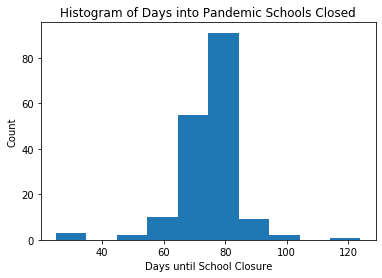

In [43]:
plt.hist(list(full.loc[:, 'DaysBeforeSClose']), bins = 10)
plt.xlabel('Days until School Closure')
plt.ylabel('Count')
plt.title('Histogram of Days into Pandemic Schools Closed')
plt.show()

The histogram gives us a good variation in the days until school closure. We also tested our models with and without these values and found the results more accurate using this metric. 

### Policy Count Experiment

Before we run our clustering algorithms, we also experimented with adding data into our model about the amount of policies that were being passed. For each country, we counted the number of policies that were passed at any level and for any amount of time. This gave each country a score for policies.

In [44]:
#%% number of policies by country
policyCount = {}
for country in countries:
    is_country = policies['ISO_A3'] == country
    count = len(policies[is_country].record_id.unique())
    policyCount[country] = count
    
policyCountdf = pd.DataFrame.from_dict(policyCount, orient = 'index').rename(columns = {0 : 'PolicyCount'})

As you may have noticed, our full dataset that we eventually run in our clustering models does not contain this information. When we added this data to our clustering models we overwhelmed the model and got that almost all the countries were in the same cluster - thus giving us no meaningful information. We decided to drop this from our model. In our figures, though, you can see some maps with coloring based on how many policies each country had.

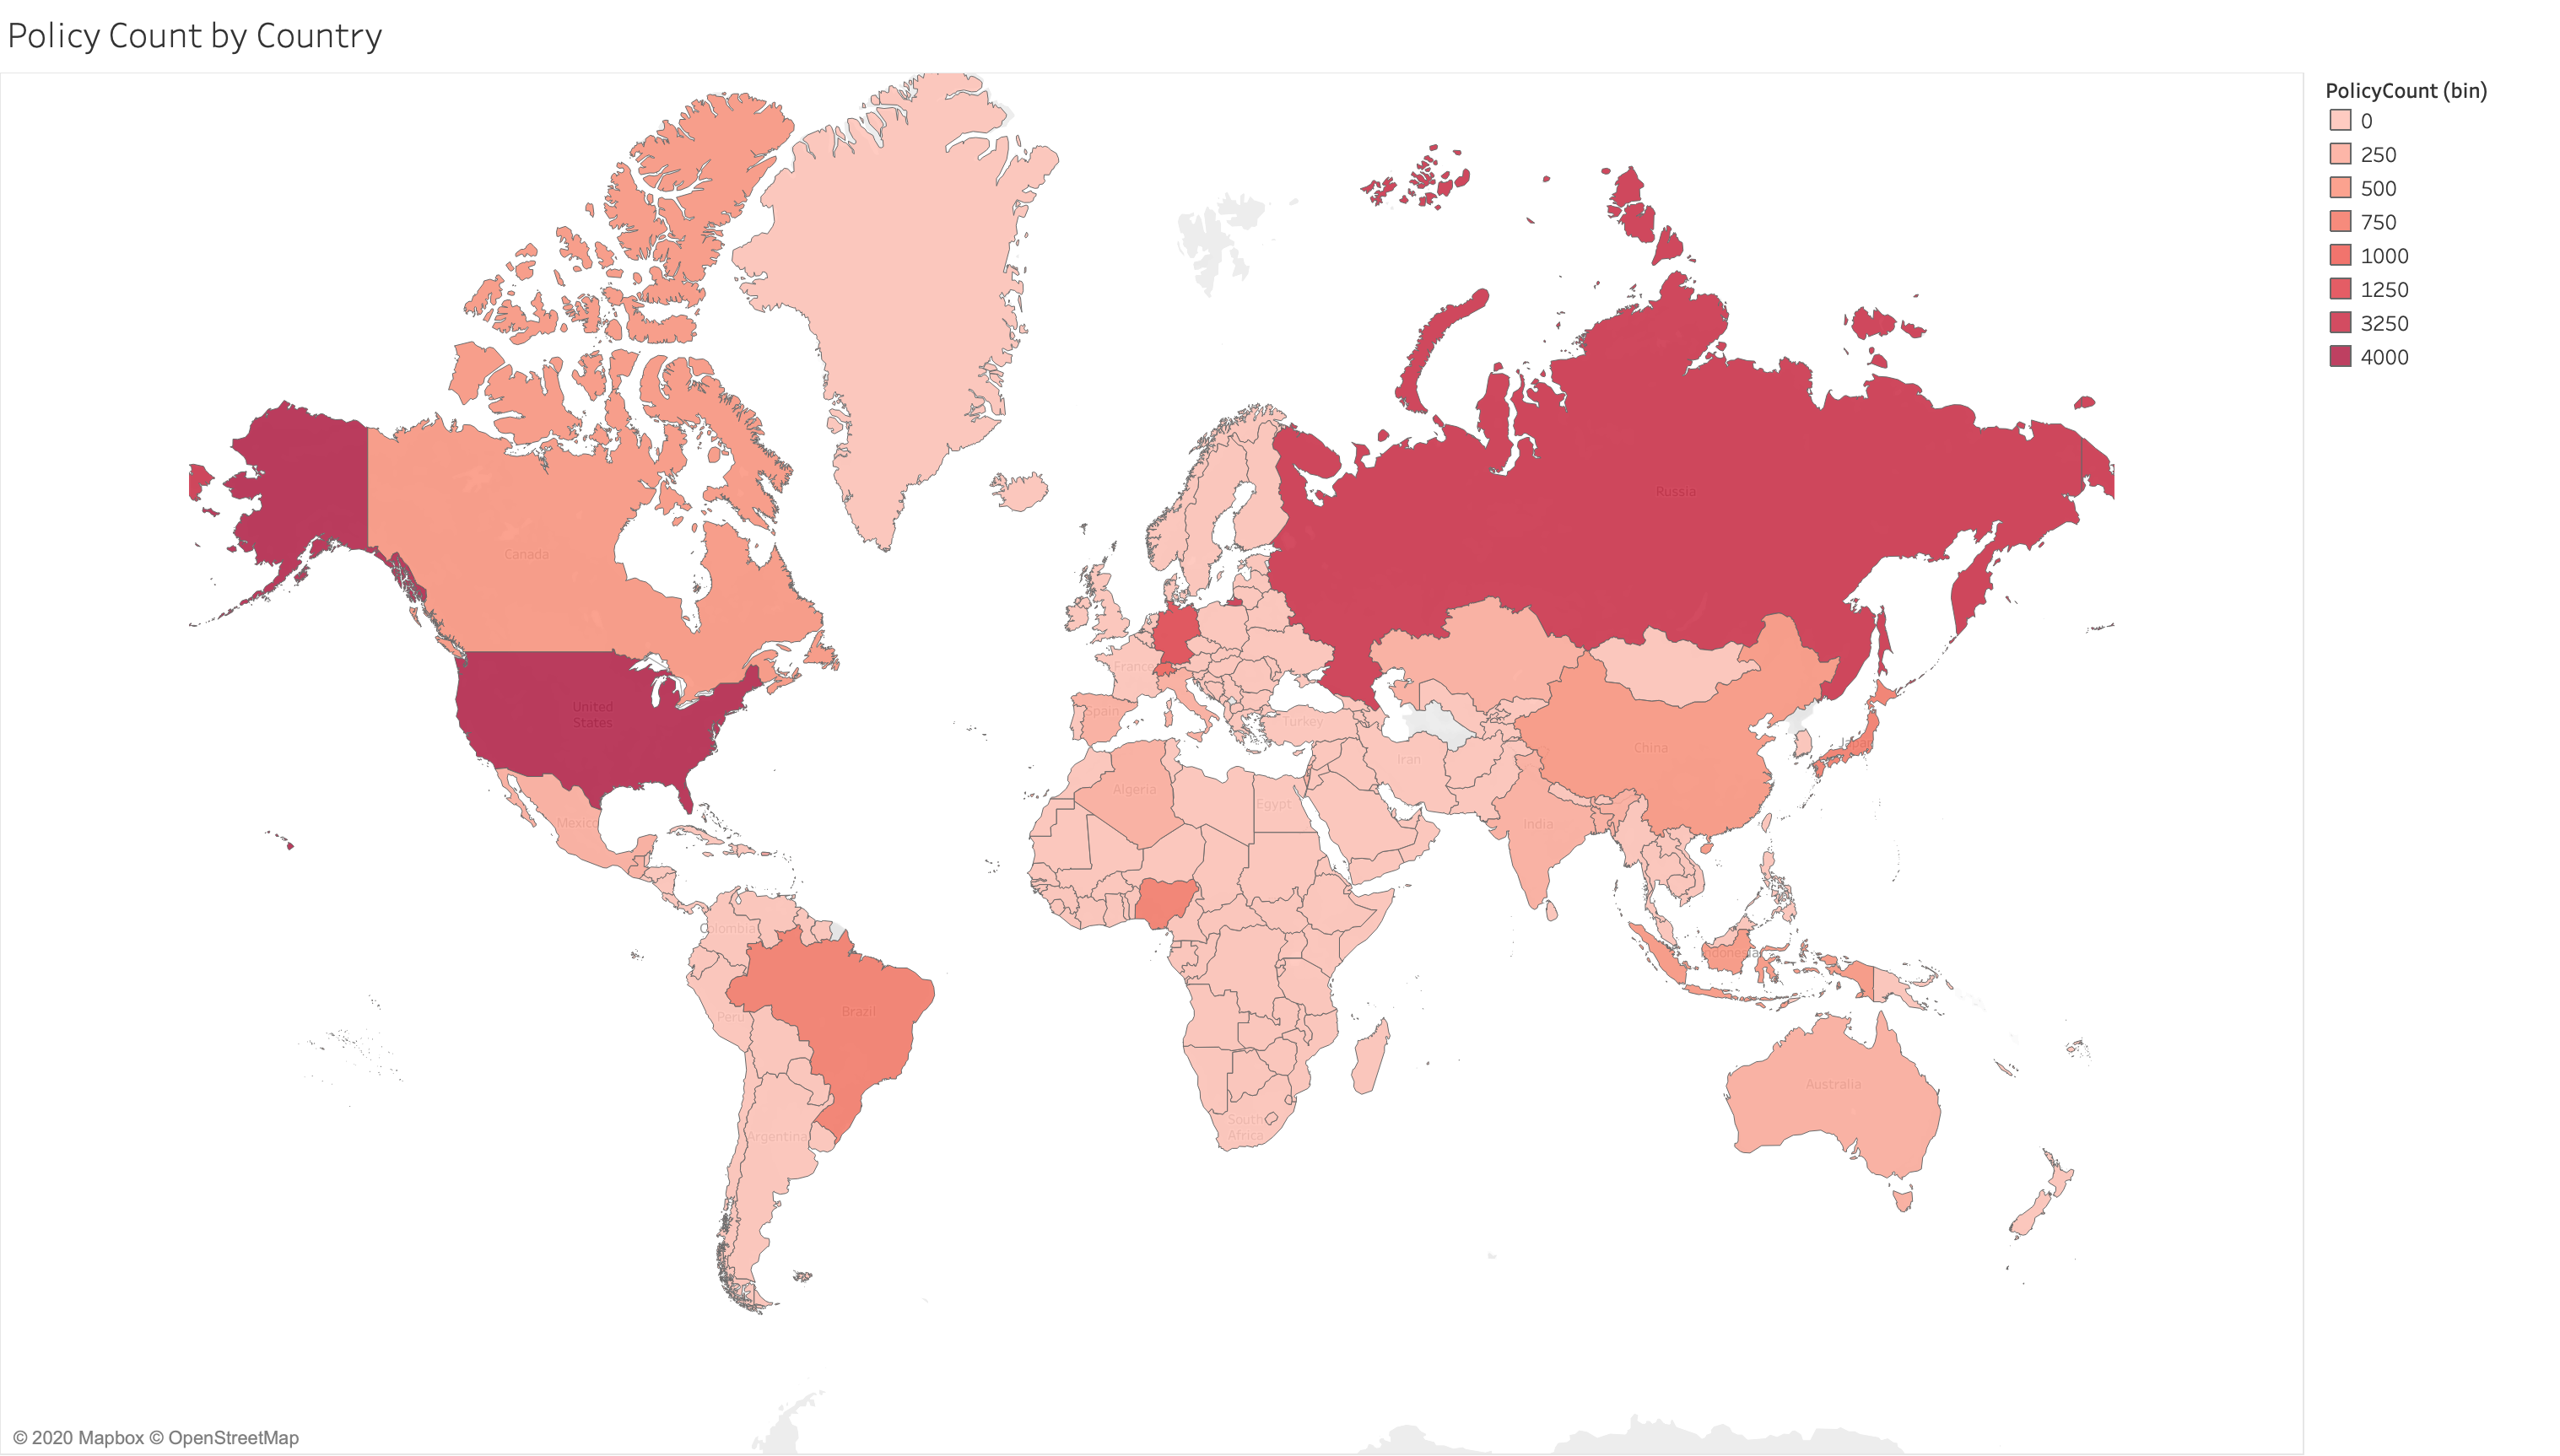

## Clustering Algorithms

### Agglomerative Clustering

Now that we have decided that we are going to use the case growth, stringency index, and school closure metrics we can look at our clustering algorithms. The first algorithm that we are going to look at is Agglomerative Clustering. We experimented with many different linkages and affinities but having complete and euclidean, respectively, seemed to give us the best results based on the data. We clustered into 5 groups to represent:
* Very poor response
* Poor Response
* Neutral Reponse
* Good Reponse
* Excellent Reponse

In [45]:
clt = AgglomerativeClustering(linkage = 'complete', affinity = 'euclidean', n_clusters = 5)
model = clt.fit(full)
labels = list(model.labels_)
#full['Country'] = full.index
country_with_cluster = full
country_with_cluster['cluster'] = labels

We then exported this data and created a map to represent the clusters.

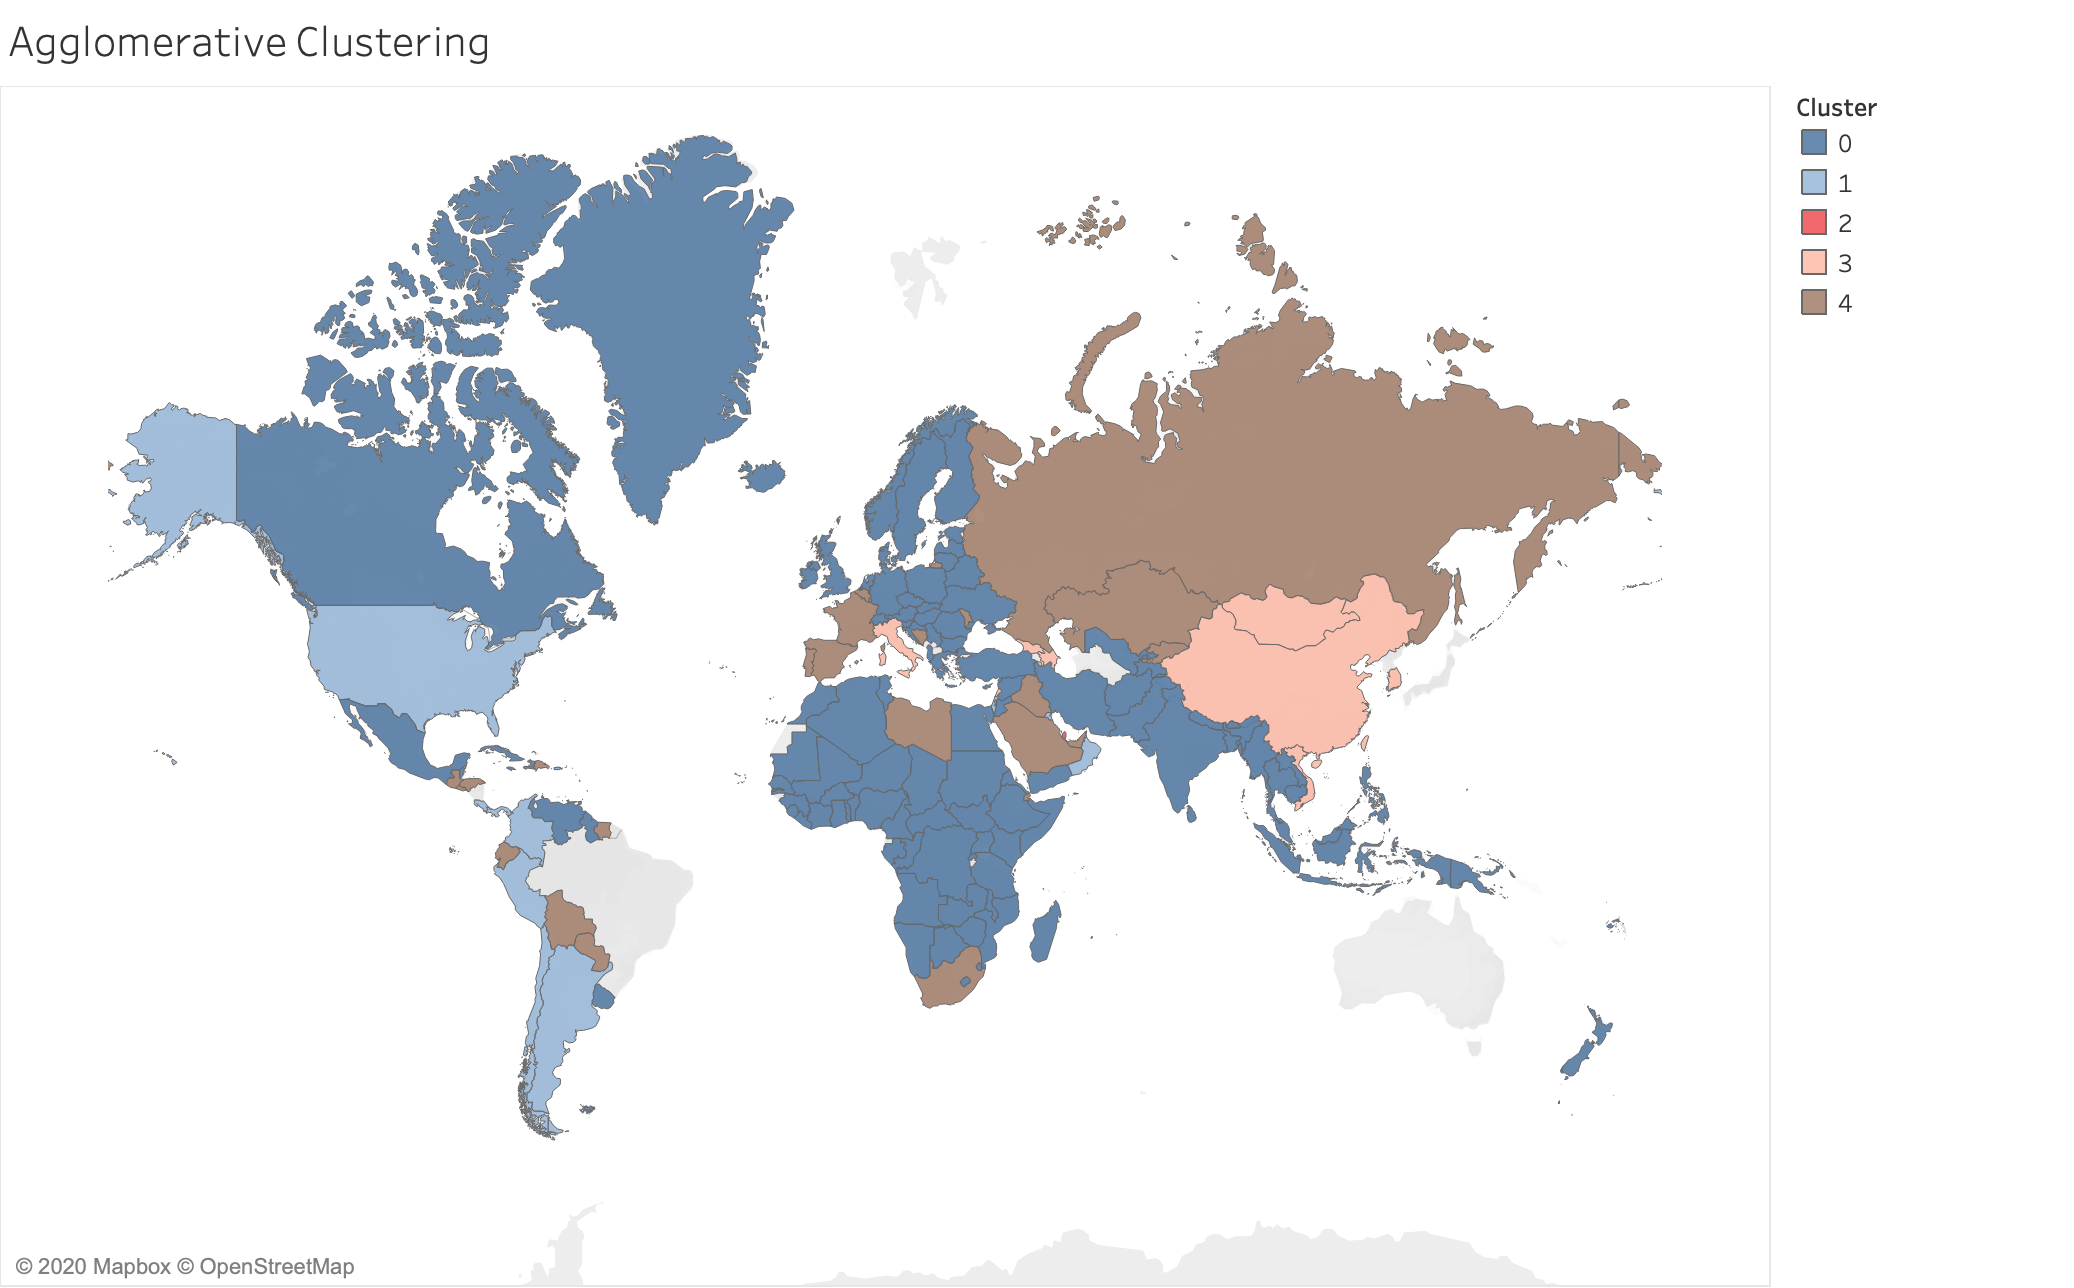

To better understand our results here we took an example country from each cluster and investigated closer the data that gave it the cluster. For cluster 0 we found that these countries had a middle level stringency index and low case counts. We gave this an excellent response since the impact to the country was minimal and the case level was still low. Next, in cluster 1 we have middle level stringency index but still a high level of cases. We called this a poor response. Cluster 2 had no countries and based on the other clusters this is very poor response. In cluster 3, there is a high stringency index and a low case count. We deemed this a good response because the countries acted swiftly in getting policies out that allowed the case count to be low. Finally, in cluster 4 we have a middle/high level stringency index but still a low value of cases. This is what we called our neutral response.

### K-Means Clustering

In addition to agglomerative clustering, we also ran a simple K-Means clustering algorithm to see the variation we would get between the models. Overall, we decided that we liked the agglomerative clustering model better because we felt like it grouped countries more appropriately. We can see though that a lot of similar countries are grouped together with each other, which helps to validate the results above.

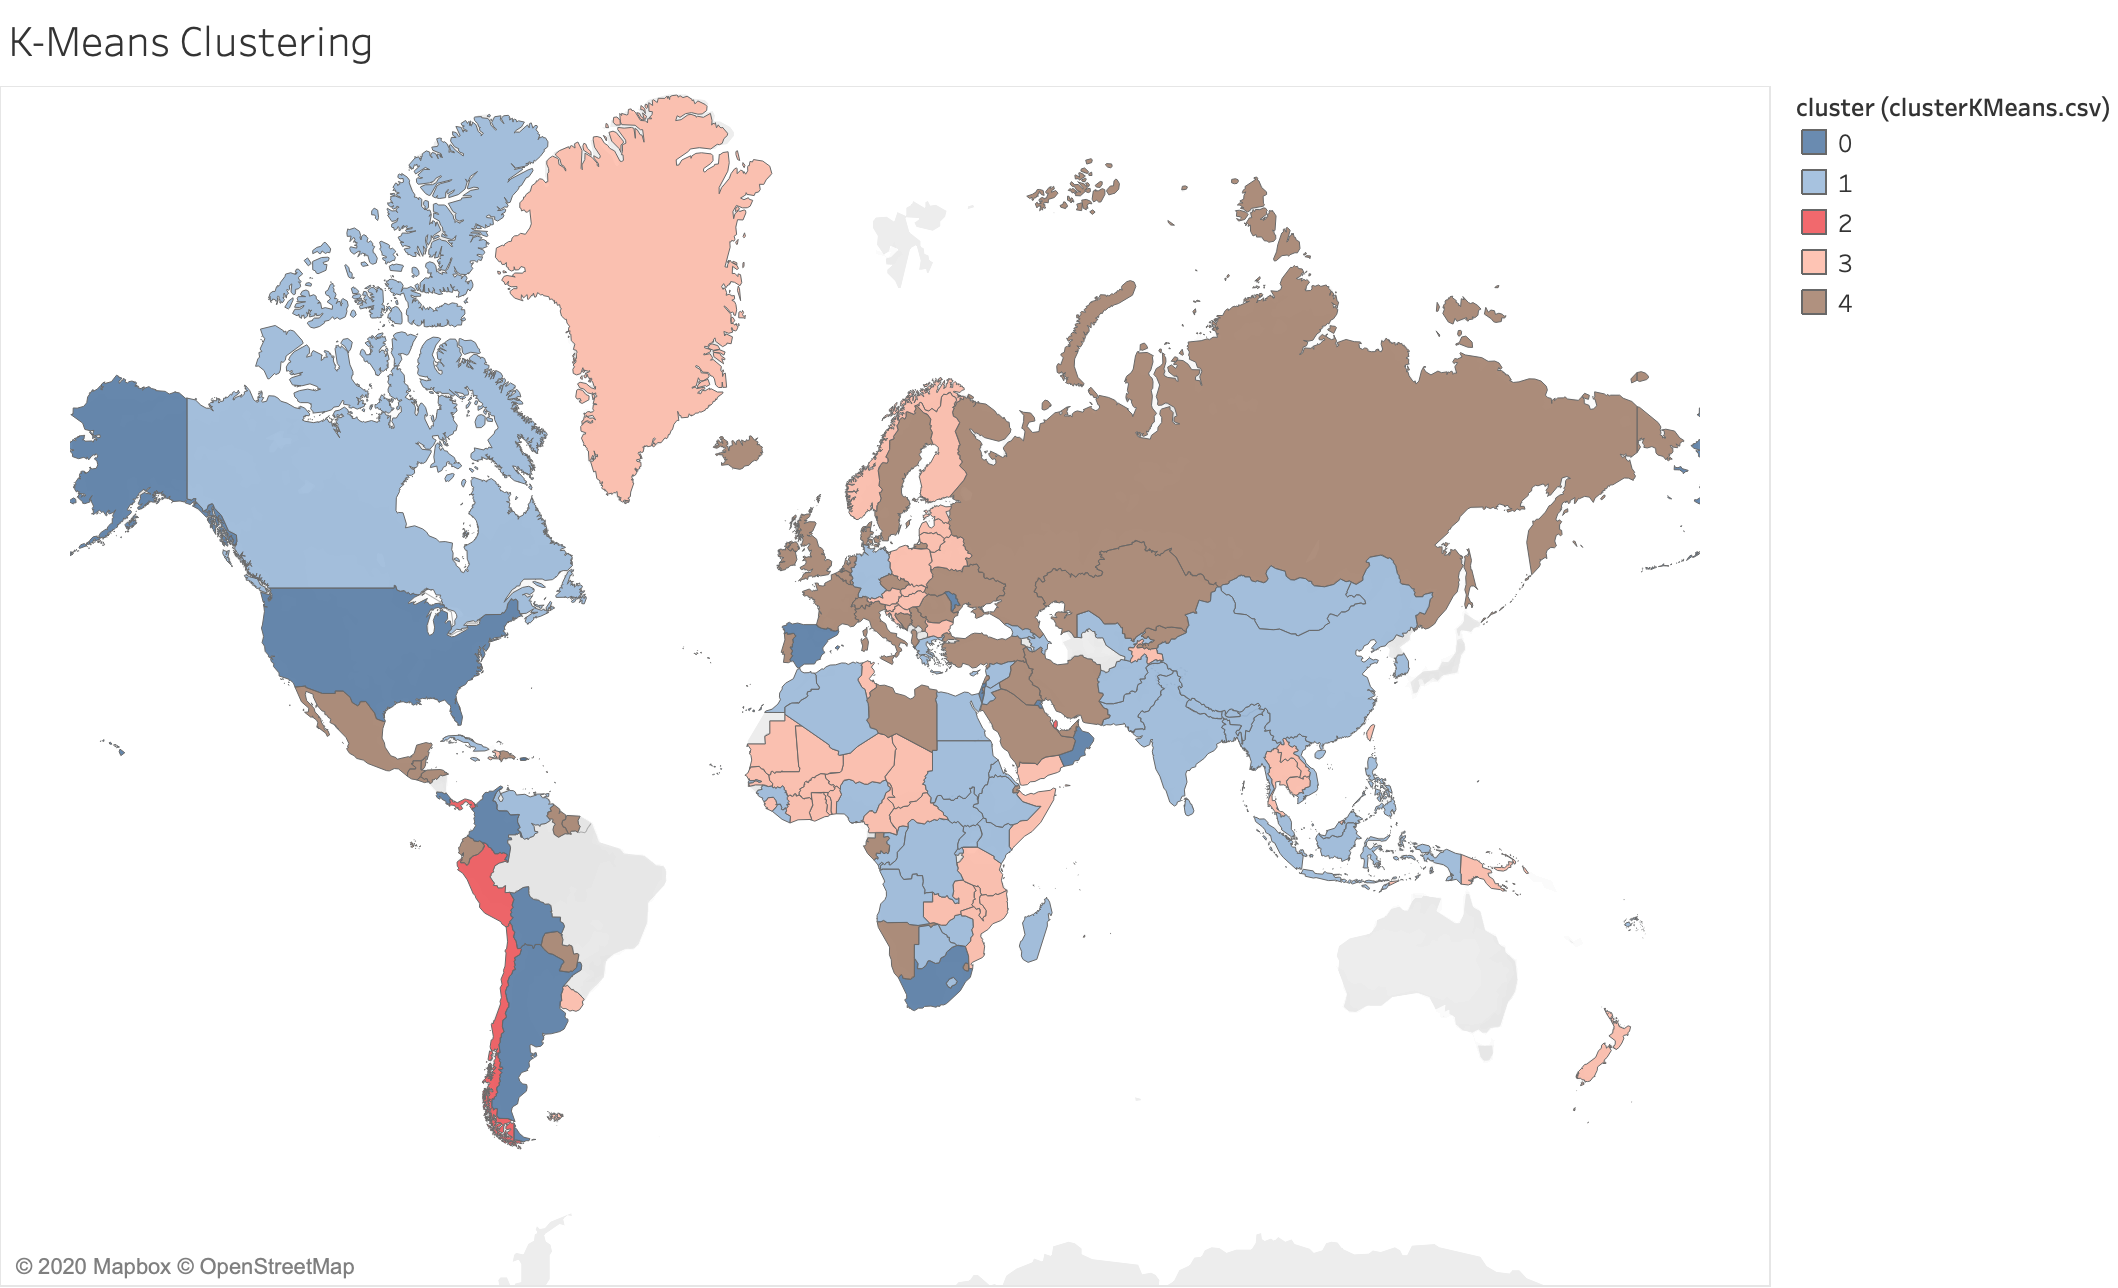